# HNSW优化测试

本notebook用于测试HNSW优化的两个主要功能：
1. 高层桥边（High-layer Bridge Edges）
2. 自适应多入口种子（Adaptive Multi-entry Seeds）

使用Text2Image数据集进行测试，并与基线HNSW进行对比。


In [1]:
# 导入必要的库
import sys
sys.path.append('/workspace/vectordbindexing')
sys.path.append('/workspace/vectordbindexing/hnsw_optimization')

import numpy as np
import time
import matplotlib.pyplot as plt
from io_utils import read_fbin, read_ibin

# 导入我们的优化模块
from hnsw_with_bridges_optimized import HNSWWithBridgesOptimized  # 使用优化版

print("所有模块导入成功！")

所有模块导入成功！


## 1. 数据加载

加载Text2Image数据集和预计算的ground truth


## 2. 快速加载选项（可选）

如果你已经保存了图结构文件，可以快速加载而无需重建第0层：

**快速加载步骤：**
1. 设置 `use_saved_graph = True`
2. 指定 `graph_file_path`
3. 运行下方创建索引的代码

这样可以跳过耗时的第0层构建，只重建第1层连接（快速很多！）


In [2]:
# 数据路径
file_path = "../Text2Image/base.10M.fbin"
query_path = "../Text2Image/query.10k.fbin"
ground_truth_path = "../Text2Image/gt.10k.ibin"
# 定义保存路径 - layer0 graph
graph_file = '/workspace/vectordbindexing/hnsw_optimization/layer0_graph.txt'
# RoarGraph index 文件路径
roargraph_index_path = '/workspace/vectordbindexing/Text2Image/t2i_10M_roar.index'


print("加载数据集...")

# 读取数据集
data_vector = read_fbin(file_path)
query_vector = read_fbin(query_path)

print(f"完整数据向量形状: {data_vector.shape}")
print(f"完整查询向量形状: {query_vector.shape}")

# ⚠️ 重要：使用较小的数据集进行测试（避免内存溢出）
n_train = len(data_vector)  # 使用 500K 数据
n_query = len(query_vector)    # 使用 1000 个查询

X = data_vector[:n_train]
Q = query_vector[:n_query]

print(f"\n使用训练数据: {X.shape} (500K)")
print(f"使用查询数据: {Q.shape} (1000)")

# 加载 ground truth 结果（从.ibin文件）
print("\n加载 ground truth 结果...")
gt_neighbors_full = read_ibin(ground_truth_path)
print(f"完整 Ground truth 形状: {gt_neighbors_full.shape}")

# 只使用前n_query个查询的ground truth
gt_neighbors = gt_neighbors_full[:n_query]
print(f"使用的 Ground truth 形状: {gt_neighbors.shape}")

print("\n✅ 数据加载完成")

np.random.seed(42)

加载数据集...
完整数据向量形状: (10000000, 200)
完整查询向量形状: (10000, 200)

使用训练数据: (10000000, 200) (500K)
使用查询数据: (10000, 200) (1000)

加载 ground truth 结果...
完整 Ground truth 形状: (10000, 500)
使用的 Ground truth 形状: (10000, 500)

✅ 数据加载完成


## 2.5. 集成版 HNSW：自动桥接边 + 多入口搜索

使用新的 `HNSWWithBridges` 类，将桥接边构建和多入口搜索直接集成到 HNSW 中。

**关键特性**：
- 构建时自动添加桥接边（基于2跳可达性检测）
- 搜索时自动使用多入口点
- 单一接口，无需手动管理多个组件


In [ ]:
print("=" * 70)
print("构建优化版 HNSW（C++核心实现）")
print("=" * 70)

# ===== 快速加载选项 =====
# 设置为True可以从保存的文件快速加载图结构
use_saved_graph = False  # 改为True以启用快速加载
use_roargraph = True
graph_file_path = '/workspace/vectordbindexing/hnsw_optimization/layer0_graph_tmp.txt'

# 创建优化版 HNSW（只构建一次！）
hnsw_optimized = HNSWWithBridgesOptimized(
    dimension=X.shape[1],
    M=64,              # M0=64, M1=32
    ef_construction=200,
    num_entry_points=4 # 默认4个入口点
)

print(f"\n快速加载模式: {'✅ 启用' if use_saved_graph else '❌ 关闭'}")
if use_saved_graph:
    print(f"将从文件加载: {graph_file_path}")
elif use_roargraph:
    print(f"将从 RoarGraph 加载: {roargraph_index_path}")

构建优化版 HNSW（C++核心实现）

快速加载模式: ❌ 关闭
将从 RoarGraph 加载: /workspace/vectordbindexing/Text2Image/t2i_10M_roar.index


: 

In [ ]:
# 构建索引（支持快速加载）
print("\n开始构建索引...")
start_time = time.time()

# 如果启用快速加载，传入文件路径
if use_saved_graph:
    hnsw_optimized.build_index(X, rebuild_graph_from=graph_file_path)
elif use_roargraph:
    hnsw_optimized.build_index(X, load_from_roargraph=roargraph_index_path)
else:
    hnsw_optimized.build_index(X)

optimized_build_time = time.time() - start_time

if use_saved_graph:
    print(f"\n✅ 从文件快速加载完成，耗时: {optimized_build_time:.2f}秒")
else:
    print(f"\n✅ 完整构建完成，耗时: {optimized_build_time:.2f}秒")

# 统计信息
stats = hnsw_optimized.get_statistics()
print(f"\n统计信息:")
print(f"  总节点数: {stats['total_nodes']}")
print(f"  维度: {stats['dimension']}")
print(f"  M0 (第0层出度): {stats['M0']}")
print(f"  M1 (第1层出度): {stats['M1']}")
print(f"  第1层节点数: {stats['layer1_nodes']} ({stats['layer1_ratio']*100:.2f}%)")
print(f"  理论第1层比例: ~{100/stats['M0']:.2f}% (P(L>=1)=1/M0)")
print(f"  实现方式: {stats['implementation']}")

# 测试单个查询
print("\n测试搜索...")
test_query = Q[0]
test_neighbors, test_stats = hnsw_optimized.search(test_query, k=100, ef_search=200, num_entry_points=4)
print(f"  找到 {len(test_neighbors)} 个邻居")
print(f"  avg_visited: {test_stats['visited_count']}")
print(f"  mean_latency: {test_stats['latency_us']:.2f} μs")
print(f"  前10个邻居: {test_neighbors[:10]}")


开始构建索引...


测试不同的入口点数量（使用同一个索引，快速！）

Ground truth 形状: (1000, 500)
测试查询数: 100

生成Latency vs Recall对比图（横轴：实际延迟，纵轴：Recall）

测试不同入口点数和ef_search组合以获得不同latency...
入口点配置: [2, 3, 4, 5, 6, 7, 8, 12, 16, 20, 24]
ef_search配置: [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

测试 2 个入口点:
  ef=50: Recall@10=0.0000, 延迟=0.37ms
  ef=100: Recall@10=0.0000, 延迟=0.44ms
  ef=150: Recall@10=0.0000, 延迟=0.63ms
  ef=200: Recall@10=0.0000, 延迟=0.87ms
  ef=250: Recall@10=0.0000, 延迟=1.05ms
  ef=300: Recall@10=0.0000, 延迟=1.29ms
  ef=350: Recall@10=0.0000, 延迟=1.48ms
  ef=400: Recall@10=0.0000, 延迟=1.68ms
  ef=450: Recall@10=0.0000, 延迟=1.89ms
  ef=500: Recall@10=0.0000, 延迟=2.32ms

测试 3 个入口点:
  ef=50: Recall@10=0.0000, 延迟=0.36ms
  ef=100: Recall@10=0.0000, 延迟=0.43ms
  ef=150: Recall@10=0.0000, 延迟=0.68ms
  ef=200: Recall@10=0.0000, 延迟=0.88ms
  ef=250: Recall@10=0.0000, 延迟=1.05ms
  ef=300: Recall@10=0.0000, 延迟=1.31ms
  ef=350: Recall@10=0.0000, 延迟=1.59ms
  ef=400: Recall@10=0.0000, 延迟=1.79ms
  ef=450: Recall@10=0.0000, 延迟=1.98ms
  e

FileNotFoundError: [Errno 2] No such file or directory: '/root/code/vectordbindexing/hnsw_optimization/latency_vs_recall_comparison.png'

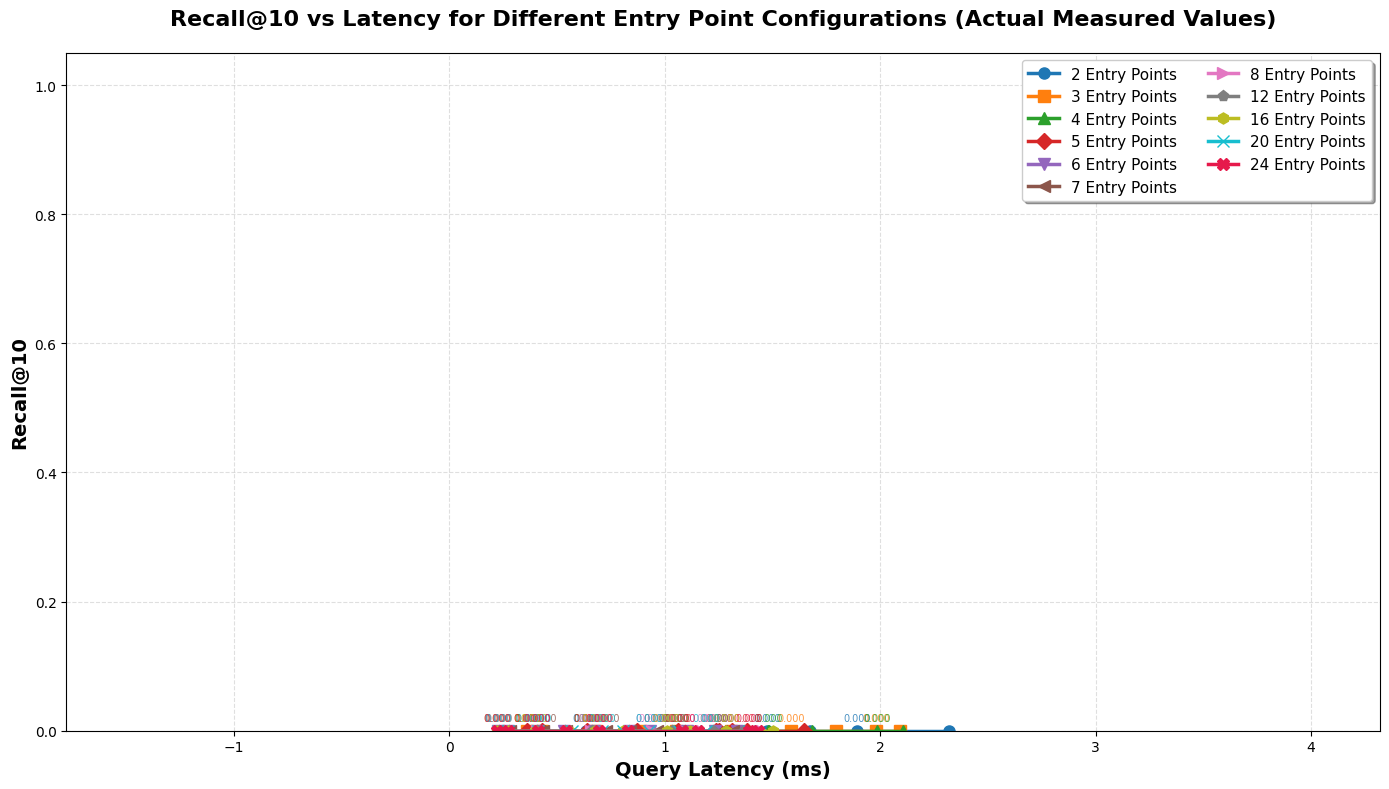

In [ ]:
print("=" * 70)
print("测试不同的入口点数量（使用同一个索引，快速！）")
print("=" * 70)

# Ground truth已从.ibin文件加载
print(f"\nGround truth 形状: {gt_neighbors.shape}")

# 测试参数
n_test_queries = min(100, len(Q))
print(f"测试查询数: {n_test_queries}")

# ===== 新版对比：不同Latency预算下的Recall对比 =====
print("\n" + "=" * 70)
print("生成Latency vs Recall对比图（横轴：实际延迟，纵轴：Recall）")
print("=" * 70)

# 入口点配置
entry_point_configs = [2, 3, 4, 5, 6, 7, 8, 12, 16, 20, 24]

# 不同的ef_search值来控制latency
ef_search_values = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

# 存储结果
detailed_results = {}

print(f"\n测试不同入口点数和ef_search组合以获得不同latency...")
print(f"入口点配置: {entry_point_configs}")
print(f"ef_search配置: {ef_search_values}")

n_test_queries_detail = 50  # 减少测试数量加快速度

for num_entries in entry_point_configs:
    detailed_results[num_entries] = {}
    print(f"\n测试 {num_entries} 个入口点:")
    
    for ef_search in ef_search_values:
        all_neighbors = []
        search_times = []
        
        for j in range(n_test_queries_detail):
            start = time.time()
            neighbors, stats = hnsw_optimized.search(
                Q[j], k=100, ef_search=ef_search, num_entry_points=num_entries
            )
            search_times.append(time.time() - start)
            # 也可以使用C++返回的延迟: stats['latency_us'] / 1000  # 转换为ms
            
            # 确保返回固定长度的数组（修复inhomogeneous shape错误）
            if isinstance(neighbors, (list, np.ndarray)):
                neighbors = np.array(neighbors)
                # 如果长度不足100，填充-1
                if len(neighbors) < 100:
                    padded = np.full(100, -1, dtype=neighbors.dtype)
                    padded[:len(neighbors)] = neighbors
                    neighbors = padded
                # 如果超过100，截断
                elif len(neighbors) > 100:
                    neighbors = neighbors[:100]
            all_neighbors.append(neighbors)
        
        all_neighbors = np.array(all_neighbors)
        # 使用hnsw_optimized.compute_recall计算recall
        recall_10 = hnsw_optimized.compute_recall(all_neighbors, gt_neighbors[:n_test_queries_detail], k=10)
        avg_time = np.mean(search_times) * 1000
        
        detailed_results[num_entries][ef_search] = {
            'recall_10': recall_10,
            'avg_time_ms': avg_time
        }
        
        print(f"  ef={ef_search}: Recall@10={recall_10:.4f}, 延迟={avg_time:.2f}ms")

# 直接使用实际测量的latency（不插值）
print("\n整理数据（使用实际latency，不插值）...")

latency_recall_data = {}

for num_entries in entry_point_configs:
    latencies = []
    recalls = []
    
    for ef_search in ef_search_values:
        latencies.append(detailed_results[num_entries][ef_search]['avg_time_ms'])
        recalls.append(detailed_results[num_entries][ef_search]['recall_10'])
    
    # 排序确保latency递增
    sorted_pairs = sorted(zip(latencies, recalls))
    sorted_latencies = [p[0] for p in sorted_pairs]
    sorted_recalls = [p[1] for p in sorted_pairs]
    
    latency_recall_data[num_entries] = {
        'latencies': sorted_latencies,
        'recalls': sorted_recalls
    }

# 绘制折线图
print("\n绘制图表...")

plt.figure(figsize=(14, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#e6194B']
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', 'h', 'x', 'X']

for i, num_entries in enumerate(entry_point_configs):
    latencies = latency_recall_data[num_entries]['latencies']
    recalls = latency_recall_data[num_entries]['recalls']
    
    plt.plot(latencies, recalls, 
             marker=markers[i], linewidth=2.5, markersize=8,
             label=f'{num_entries} Entry Points', color=colors[i])
    
    # 添加数值标签（只在部分点上标注，避免过于拥挤）
    for j, (lat, rec) in enumerate(zip(latencies, recalls)):
        if j % 2 == 0:  # 每隔一个点标注
            plt.text(lat, rec + 0.015, f'{rec:.3f}', 
                    ha='center', fontsize=7, color=colors[i], alpha=0.8)

plt.xlabel('Query Latency (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Recall@10', fontsize=14, fontweight='bold')
plt.title('Recall@10 vs Latency for Different Entry Point Configurations (Actual Measured Values)', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='best', frameon=True, shadow=True, ncol=2)
plt.grid(True, alpha=0.4, linestyle='--')

# 动态计算x轴范围
all_latencies = []
for num_entries in entry_point_configs:
    all_latencies.extend(latency_recall_data[num_entries]['latencies'])
min_lat = min(all_latencies)
max_lat = max(all_latencies)
plt.xlim([min_lat - 2, max_lat + 2])
plt.ylim([0, 1.05])

plt.tight_layout()
plt.savefig('/workspace/vectordbindexing/hnsw_optimization/latency_vs_recall_comparison.png', 
            dpi=300, bbox_inches='tight')
print("\n✅ 图表已保存到: latency_vs_recall_comparison.png")
plt.show()

# 打印数据表格（显示每个配置的实际latency）
print("\n" + "=" * 70)
print("Latency vs Recall@10 数据表格（实际测量值）")
print("=" * 70)

for num_entries in entry_point_configs:
    latencies = latency_recall_data[num_entries]['latencies']
    recalls = latency_recall_data[num_entries]['recalls']
    
    print(f"\n{num_entries} 个入口点:")
    print(f"{'ef_search':<12} {'Latency(ms)':<15} {'Recall@10':<12}")
    print("-" * 40)
    
    for j, ef_search in enumerate(ef_search_values):
        print(f"{ef_search:<12} {latencies[j]:<15.3f} {recalls[j]:<12.4f}")

print("\n✅ Latency vs Recall对比图生成完成！")
print("注意：每条折线的横坐标（latency）是该配置的实际测量值，因此不同折线的点位置会不同。")

In [ ]:
print(f"\n保存第0层图结构到: {graph_file}")
hnsw_optimized.save_layer0(graph_file)
print("✅ 保存完成！后续测试可以使用 rebuild_graph_from 参数快速加载")

## 相同latency -> recall
## latency -> acc 曲线图
## 跟roargraph的比较：精度/lat；加上更新开销(对比)